<a href="https://colab.research.google.com/github/ahmedwalidahmad-debug/car-type-classification/blob/main/EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
# ======================================
# 1️⃣ Imports
# ======================================
import os, shutil, random
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import scipy.io
import kagglehub

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import TopKCategoricalAccuracy


In [68]:
# ======================================
# 2️⃣ Download Dataset
# ======================================
print("Downloading dataset...")
DATASET_PATH = kagglehub.dataset_download("eduardo4jesus/stanford-cars-dataset")
print("Dataset path:", DATASET_PATH)

IMAGES_PATH, ANNOS_PATH = None, None
for root, dirs, files in os.walk(DATASET_PATH):
    if "cars_train_annos.mat" in files:
        ANNOS_PATH = os.path.join(root, "cars_train_annos.mat")
    if os.path.basename(root) == "cars_train":
        IMAGES_PATH = root

print("Images path:", IMAGES_PATH)
print("Annotations path:", ANNOS_PATH)


Using Colab cache for faster access to the 'stanford-cars-dataset' dataset.
Dataset path: /kaggle/input/stanford-cars-dataset
Images path: /kaggle/input/stanford-cars-dataset/cars_train/cars_train
Annotations path: /kaggle/input/stanford-cars-dataset/car_devkit/devkit/cars_train_annos.mat


In [69]:
# ======================================
# 3️⃣ Load Annotations
# ======================================
annos = scipy.io.loadmat(ANNOS_PATH)
annotations = annos["annotations"][0]

class_dict = {}
for ann in annotations:
    img_name = ann[5][0]
    class_id = int(ann[4][0][0])
    class_dict.setdefault(class_id, []).append(img_name)

print("Total classes:", len(class_dict))


Total classes: 196


In [70]:
# ======================================
# 4️⃣ Select Top 40 Classes
# ======================================
# ترتيب الكلاسات حسب عدد الصور
sorted_classes = sorted(class_dict.items(), key=lambda x: len(x[1]), reverse=True)
selected_classes = [cls for cls, imgs in sorted_classes[:40]]

OUTPUT_PATH = "/kaggle/working/cars_40_classes"
os.makedirs(OUTPUT_PATH, exist_ok=True)

missing = 0
for cls in selected_classes:
    class_folder = os.path.join(OUTPUT_PATH, f"class_{cls}")
    os.makedirs(class_folder, exist_ok=True)
    for img in class_dict[cls]:
        src = os.path.join(IMAGES_PATH, img)
        dst = os.path.join(class_folder, img)
        if os.path.exists(src):
            shutil.copy(src, dst)
        else:
            missing += 1

print("✅ Created dataset with 40 classes at:", OUTPUT_PATH)
print("⚠️ Missing images:", missing)


✅ Created dataset with 40 classes at: /kaggle/working/cars_40_classes
⚠️ Missing images: 0


In [71]:
# ======================================
# 5️⃣ Build DataFrame
# ======================================
DATA_PATH = OUTPUT_PATH
data = []
for cls in sorted(os.listdir(DATA_PATH)):
    if not cls.startswith("class_"):
        continue
    cls_path = os.path.join(DATA_PATH, cls)
    for img in os.listdir(cls_path):
        if img.lower().endswith(('.jpg','.jpeg','.png')):
            data.append({"filename": os.path.join(cls_path, img), "label": cls})

df = pd.DataFrame(data)
print("Total images:", len(df))
print("Total classes:", df["label"].nunique())


Total images: 1847
Total classes: 40


In [72]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ======================================
# 6️⃣ Train / Validation / Test Split (70% / 10% / 20%)
# ======================================

# الطريقة البديلة: نفصل test أولًا، ثم val، ثم train
# بس بنفس النتيجة

# أولًا: فصل 20% test
df_temp, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

# ثانيًا: من الباقي (80%)، فصل 10% val (يعني test_size=0.1 / 0.8 = 0.125 زي ما كان)
train_df, val_df = train_test_split(
    df_temp,
    test_size=0.125,
    stratify=df_temp["label"],
    random_state=42
)

# أو طريقة تانية مباشرة بدون حسابات: استخدم proportions
# بس sklearn مش بيدعم multi-split مباشر، فهنعملها stepwise زي فوق

IMG_SIZE = 299
BATCH_SIZE = 32

# Data augmentation للـ train فقط
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.25,
    shear_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3]
)

# Validation و Test بدون augmentation
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Generators
train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True
)
print("Class names and their indices:")
print(train_gen.class_indices)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="label",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

NUM_CLASSES = len(train_gen.class_indices)
print("NUM_CLASSES:", NUM_CLASSES)

total_samples = len(df)
print(f"Train samples: {len(train_df)} ({len(train_df)/total_samples*100:.1f}%)")
print(f"Validation samples: {len(val_df)} ({len(val_df)/total_samples*100:.1f}%)")
print(f"Test samples: {len(test_df)} ({len(test_df)/total_samples*100:.1f}%)")

Found 1292 validated image filenames belonging to 40 classes.
Class names and their indices:
{'class_1': 0, 'class_107': 1, 'class_109': 2, 'class_112': 3, 'class_114': 4, 'class_115': 5, 'class_119': 6, 'class_121': 7, 'class_123': 8, 'class_144': 9, 'class_147': 10, 'class_148': 11, 'class_153': 12, 'class_161': 13, 'class_162': 14, 'class_165': 15, 'class_167': 16, 'class_171': 17, 'class_179': 18, 'class_182': 19, 'class_191': 20, 'class_194': 21, 'class_20': 22, 'class_24': 23, 'class_34': 24, 'class_43': 25, 'class_44': 26, 'class_53': 27, 'class_56': 28, 'class_59': 29, 'class_6': 30, 'class_65': 31, 'class_72': 32, 'class_73': 33, 'class_79': 34, 'class_8': 35, 'class_81': 36, 'class_82': 37, 'class_95': 38, 'class_98': 39}
Found 185 validated image filenames belonging to 40 classes.
Found 370 validated image filenames belonging to 40 classes.
NUM_CLASSES: 40
Train samples: 1292 (70.0%)
Validation samples: 185 (10.0%)
Test samples: 370 (20.0%)


EfficientNetB0 model

In [73]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ======================================
# 1️⃣ Load pre-trained EfficientNetB0
# ======================================
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Freeze base_model initially
base_model.trainable = False

# Add classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)  # Prevent overfitting
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_4         │ (None, 299, 299,  │          0 │ input_layer_2[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_2     │ (None, 299, 299,  │          7 │ rescaling_4[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_5         │ (None, 299, 299,  │          0 │ normalization_2[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 301, 301,  │          0 │ rescaling_5[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 150, 150,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 150, 150,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 150, 150,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 150, 150,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 150, 150,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 150, 150,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 150, 150,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 150, 150,  │        512 │ block1a_se_excit

 Total params: 4,100,811 (15.64 MB)

 Trainable params: 51,240 (200.16 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [74]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
]


In [75]:
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1),
    ModelCheckpoint("best_model.h5", monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,   # Phase 1
    callbacks=callbacks
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0441 - loss: 3.7253 - top_k_categorical_accuracy: 0.1997

41/41 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.0447 - loss: 3.7216 - top_k_categorical_accuracy: 0.2013 - val_accuracy: 0.2595 - val_loss: 3.1575 - val_top_k_categorical_accuracy: 0.5838 - learning_rate: 0.0010
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2447 - loss: 3.0438 - top_k_categorical_accuracy: 0.5698   

41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.2450 - loss: 3.0420 - top_k_categorical_accuracy: 0.5706 - val_accuracy: 0.3784 - val_loss: 2.7665 - val_top_k_categorical_accuracy: 0.6919 - learning_rate: 0.0010
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.3803 - loss: 2.6084 - top_k_categorical_accuracy: 0.7214

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.3799 - loss: 2.6084 - top_k_categorical_accuracy: 0.7214 - val_accuracy: 0.4108 - val_loss: 2.5145 - val_top_k_categorical_accuracy: 0.7405 - learning_rate: 0.0010
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 972ms/step - accuracy: 0.4640 - loss: 2.3605 - top_k_categorical_accuracy: 0.8116

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.4637 - loss: 2.3597 - top_k_categorical_accuracy: 0.8117 - val_accuracy: 0.4649 - val_loss: 2.3080 - val_top_k_categorical_accuracy: 0.7838 - learning_rate: 0.0010
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.5207 - loss: 2.1257 - top_k_categorical_accuracy: 0.8548 - val_accuracy: 0.4486 - val_loss: 2.1707 - val_top_k_categorical_accuracy: 0.8054 - learning_rate: 0.0010
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 959ms/step - accuracy: 0.5631 - loss: 1.9642 - top_k_categorical_accuracy: 0.8810

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.5629 - loss: 1.9642 - top_k_categorical_accuracy: 0.8809 - val_accuracy: 0.4811 - val_loss: 2.0444 - val_top_k_categorical_accuracy: 0.8270 - learning_rate: 0.0010
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 952ms/step - accuracy: 0.5967 - loss: 1.8472 - top_k_categorical_accuracy: 0.8957

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 997ms/step - accuracy: 0.5969 - loss: 1.8464 - top_k_categorical_accuracy: 0.8957 - val_accuracy: 0.4973 - val_loss: 1.9721 - val_top_k_categorical_accuracy: 0.8000 - learning_rate: 0.0010
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 999ms/step - accuracy: 0.6342 - loss: 1.6823 - top_k_categorical_accuracy: 0.9103

41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.6338 - loss: 1.6835 - top_k_categorical_accuracy: 0.9100 - val_accuracy: 0.5405 - val_loss: 1.8682 - val_top_k_categorical_accuracy: 0.8649 - learning_rate: 0.0010
Epoch 9/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 983ms/step - accuracy: 0.6616 - loss: 1.5990 - top_k_categorical_accuracy: 0.9082

41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.6615 - loss: 1.5990 - top_k_categorical_accuracy: 0.9084 - val_accuracy: 0.5514 - val_loss: 1.8081 - val_top_k_categorical_accuracy: 0.8649 - learning_rate: 0.0010
Epoch 10/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.6705 - loss: 1.5204 - top_k_categorical_accuracy: 0.9131

41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6706 - loss: 1.5201 - top_k_categorical_accuracy: 0.9134 - val_accuracy: 0.5622 - val_loss: 1.7636 - val_top_k_categorical_accuracy: 0.8595 - learning_rate: 0.0010


In [76]:
# Unfreeze all layers for fine-tuning
base_model.trainable = True

# Compile with lower LR
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy", TopKCategoricalAccuracy(k=5)]
)

# Continue training
history_ft = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,   # Phase 2
    callbacks=callbacks
)


Epoch 1/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.3534 - loss: 2.4864 - top_k_categorical_accuracy: 0.7085 - val_accuracy: 0.4973 - val_loss: 1.7032 - val_top_k_categorical_accuracy: 0.8324 - learning_rate: 1.0000e-04
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6064 - loss: 1.7278 - top_k_categorical_accuracy: 0.8877

41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.6069 - loss: 1.7257 - top_k_categorical_accuracy: 0.8880 - val_accuracy: 0.5730 - val_loss: 1.4597 - val_top_k_categorical_accuracy: 0.9081 - learning_rate: 1.0000e-04
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7028 - loss: 1.3665 - top_k_categorical_accuracy: 0.9246

41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7036 - loss: 1.3635 - top_k_categorical_accuracy: 0.9251 - val_accuracy: 0.6000 - val_loss: 1.3227 - val_top_k_categorical_accuracy: 0.8919 - learning_rate: 1.0000e-04
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7930 - loss: 0.9828 - top_k_categorical_accuracy: 0.9684

41/41 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.7933 - loss: 0.9821 - top_k_categorical_accuracy: 0.9684 - val_accuracy: 0.6919 - val_loss: 1.1531 - val_top_k_categorical_accuracy: 0.9243 - learning_rate: 1.0000e-04
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8460 - loss: 0.7577 - top_k_categorical_accuracy: 0.9791

41/41 ━━━━━━━━━━━━━━━━━━━━ 48s 1s/step - accuracy: 0.8460 - loss: 0.7575 - top_k_categorical_accuracy: 0.9792 - val_accuracy: 0.7243 - val_loss: 1.0444 - val_top_k_categorical_accuracy: 0.9243 - learning_rate: 1.0000e-04
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8908 - loss: 0.5990 - top_k_categorical_accuracy: 0.9885

41/41 ━━━━━━━━━━━━━━━━━━━━ 51s 1s/step - accuracy: 0.8907 - loss: 0.5993 - top_k_categorical_accuracy: 0.9884 - val_accuracy: 0.7676 - val_loss: 0.9413 - val_top_k_categorical_accuracy: 0.9351 - learning_rate: 1.0000e-04
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9149 - loss: 0.4828 - top_k_categorical_accuracy: 0.9940 - val_accuracy: 0.7676 - val_loss: 0.8844 - val_top_k_categorical_accuracy: 0.9459 - learning_rate: 1.0000e-04
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9362 - loss: 0.3967 - top_k_categorical_accuracy: 0.9973 - val_accuracy: 0.7622 - val_loss: 0.8125 - val_top_k_categorical_accuracy: 0.9514 - learning_rate: 1.0000e-04
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9606 - loss: 0.3312 - top_k_categorical_accuracy: 0.9995

41/41 ━━━━━━━━━━━━━━━━━━━━ 46s 1s/step - accuracy: 0.9606 - loss: 0.3310 - top_k_categorical_accuracy: 0.9994 - val_accuracy: 0.8108 - val_loss: 0.7525 - val_top_k_categorical_accuracy: 0.9622 - learning_rate: 1.0000e-04
Epoch 10/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9672 - loss: 0.2838 - top_k_categorical_accuracy: 0.9993 - val_accuracy: 0.8054 - val_loss: 0.7073 - val_top_k_categorical_accuracy: 0.9676 - learning_rate: 1.0000e-04
Epoch 11/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.9696 - loss: 0.2423 - top_k_categorical_accuracy: 0.9988 - val_accuracy: 0.7946 - val_loss: 0.6795 - val_top_k_categorical_accuracy: 0.9568 - learning_rate: 1.0000e-04
Epoch 12/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9709 - loss: 0.2118 - top_k_categorical_accuracy: 1.0000
Epoch 12: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
41/41 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.9709 - loss: 0.2116 - top_k_categorical_accuracy: 1.0000 - val

41/41 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.9842 - loss: 0.1635 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8162 - val_loss: 0.6280 - val_top_k_categorical_accuracy: 0.9622 - learning_rate: 5.0000e-05
Epoch 15/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.9865 - loss: 0.1558 - top_k_categorical_accuracy: 1.0000 - val_accuracy: 0.8054 - val_loss: 0.6116 - val_top_k_categorical_accuracy: 0.9676 - learning_rate: 5.0000e-05


In [77]:
# ======================================
# 8️⃣ Final Evaluation and Test
# ======================================
val_loss, val_acc, val_top5 = model.evaluate(val_gen)
print("Validation Accuracy:", val_acc)
print("Validation Top-5 Accuracy:", val_top5)
test_loss, test_acc, test_top5 = model.evaluate(test_gen)
print("Test accuracy: ", test_acc)
print("Test Top-5 accuracy: ", test_top5)

6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 209ms/step - accuracy: 0.8139 - loss: 0.6389 - top_k_categorical_accuracy: 0.9602
Validation Accuracy: 0.816216230392456
Validation Top-5 Accuracy: 0.9621621370315552
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.8526 - loss: 0.5091 - top_k_categorical_accuracy: 0.9783
Test accuracy:  0.8432432413101196
Test Top-5 accuracy:  0.9756757020950317


Prediction Function

In [78]:
import numpy as np
from tensorflow.keras.preprocessing import image

def preprocess_car_image(img_pil):
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    return np.expand_dims(img, axis=0)

def get_car_prediction(img_pil, top_k=5):
    tensor_img = preprocess_car_image(img_pil)

    preds = model.predict(tensor_img)
    preds = preds[0]  # shape: (NUM_CLASSES,)

    sorted_idx = np.argsort(preds)[::-1]

    print("\n=== Prediction Summary ===")
    for rank, idx in enumerate(sorted_idx[:top_k], start=1):
        class_name = list(train_gen.class_indices.keys())[idx]
        confidence = preds[idx] * 100
        print(f"{rank}. {class_name} — {confidence:.2f}%")

    return sorted_idx[:top_k]


In [79]:
from PIL import Image
import numpy as np

# Convert index → class name
idx_to_class = {v: k for k, v in train_gen.class_indices.items()}

def check_prediction(img_pil, true_label):
    # Resize + preprocess
    img = img_pil.resize((IMG_SIZE, IMG_SIZE))
    img = np.array(img).astype("float32")
    img = preprocess_input(img)
    img = np.expand_dims(img, axis=0)

    # Predict
    preds = model.predict(img)[0]
    pred_idx = np.argmax(preds)
    pred_class = idx_to_class[pred_idx]
    confidence = preds[pred_idx] * 100

    # Compare
    is_correct = (pred_class == true_label)

    print("\n=== Prediction Check ===")
    print("True Label:      ", true_label)
    print("Predicted Label: ", pred_class)
    print(f"Confidence:       {confidence:.2f}%")
    print("Correct:", "YES " if is_correct else "NO ")

    return is_correct, pred_class, confidence


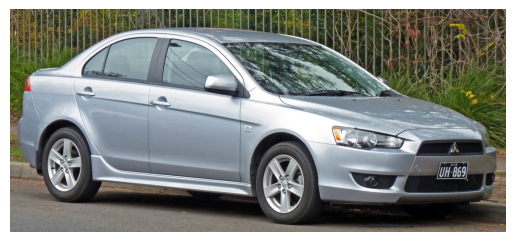

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step

=== Prediction Check ===
True Label:       class_167
Predicted Label:  class_167
Confidence:       55.06%
Correct: YES 


(True, 'class_167', np.float32(55.05868))

In [83]:
sample = val_df.sample(1).iloc[0]
img_path = sample["filename"]
true_label = sample["label"]

img_pil = Image.open(img_path).convert("RGB")

plt.imshow(img_pil)
plt.axis("off")
plt.show()

check_prediction(img_pil, true_label)


In [84]:
history.history


{'accuracy': [0.0712074339389801,
  0.2608359158039093,
  0.3622291088104248,
  0.44969040155410767,
  0.5116099119186401,
  0.5534055829048157,
  0.6052631735801697,
  0.6191950440406799,
  0.6609907150268555,
  0.6749225854873657],
 'loss': [3.5712037086486816,
  2.9660260677337646,
  2.6084094047546387,
  2.326833486557007,
  2.128962755203247,
  1.9671791791915894,
  1.8130499124526978,
  1.7310267686843872,
  1.597602367401123,
  1.5075135231018066],
 'top_k_categorical_accuracy': [0.26393190026283264,
  0.603715181350708,
  0.7252321839332581,
  0.8150154948234558,
  0.8637771010398865,
  0.8761609792709351,
  0.8947368264198303,
  0.900928795337677,
  0.9179566502571106,
  0.9280185699462891],
 'val_accuracy': [0.2594594657421112,
  0.37837839126586914,
  0.41081079840660095,
  0.4648648500442505,
  0.4486486613750458,
  0.4810810685157776,
  0.4972972869873047,
  0.5405405163764954,
  0.5513513684272766,
  0.5621621608734131],
 'val_loss': [3.157464027404785,
  2.76648545265197

In [85]:
history_ft.history


{'accuracy': [0.42337462306022644,
  0.6261609792709351,
  0.7368420958518982,
  0.806501567363739,
  0.8475232124328613,
  0.8869969248771667,
  0.9164086580276489,
  0.9264705777168274,
  0.9582043290138245,
  0.9674922823905945,
  0.9643962979316711,
  0.970588207244873,
  0.9806501269340515,
  0.9814241528511047,
  0.9876161217689514],
 'loss': [2.3172247409820557,
  1.6399513483047485,
  1.240780234336853,
  0.9538248181343079,
  0.7489253878593445,
  0.6130251884460449,
  0.47900664806365967,
  0.4053342938423157,
  0.32230016589164734,
  0.27964305877685547,
  0.24345014989376068,
  0.20482029020786285,
  0.18128733336925507,
  0.1642341911792755,
  0.15505747497081757],
 'top_k_categorical_accuracy': [0.7469040155410767,
  0.8993808031082153,
  0.9419504404067993,
  0.9713622331619263,
  0.9806501269340515,
  0.9876161217689514,
  0.9930340647697449,
  0.995356023311615,
  0.9992260336875916,
  0.9984520077705383,
  0.9984520077705383,
  1.0,
  0.9984520077705383,
  1.0,
  1.0]